In [10]:
import os
HOME = os.getcwd()
print(HOME)

/content/ByteTrack


In [11]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd '/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)'
!ls
!pwd

/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)
Data.yaml	    README.roboflow.txt  train			  Videos      yolov8x.pt
README.dataset.txt  runs		 VID-20230805-WA0001.mp4  yolov8s.pt
/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)


In [13]:
!pip install -q gdown
%cd '/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)'


/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)


In [14]:
!pip install supervision==0.1.0

import cv2
import supervision as sv
import numpy as np

SOURCE_VIDEO_PATH =  '/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)/Videos/video_20230804_121505.mp4'

try:
    video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
except Exception as e:
    print(f"Error: {e}")

Error: module 'supervision' has no attribute 'VideoInfo'


In [15]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [9]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.1.0


In [8]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [16]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [17]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

**Tracking utils**

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [18]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

Load pre-trained YOLOv8 model

In [19]:
from ultralytics import YOLO

MODEL = "/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)/runs/detect/train/weights/best.pt"

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


In [20]:
# Predict and annotate single frame

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - 14days, wm
CLASS_ID = [0,1]



0: 640x384 72 7days-chickss, 1 wm, 211.3ms
Speed: 12.5ms preprocess, 211.3ms inference, 65.3ms postprocess per image at shape (1, 3, 640, 384)


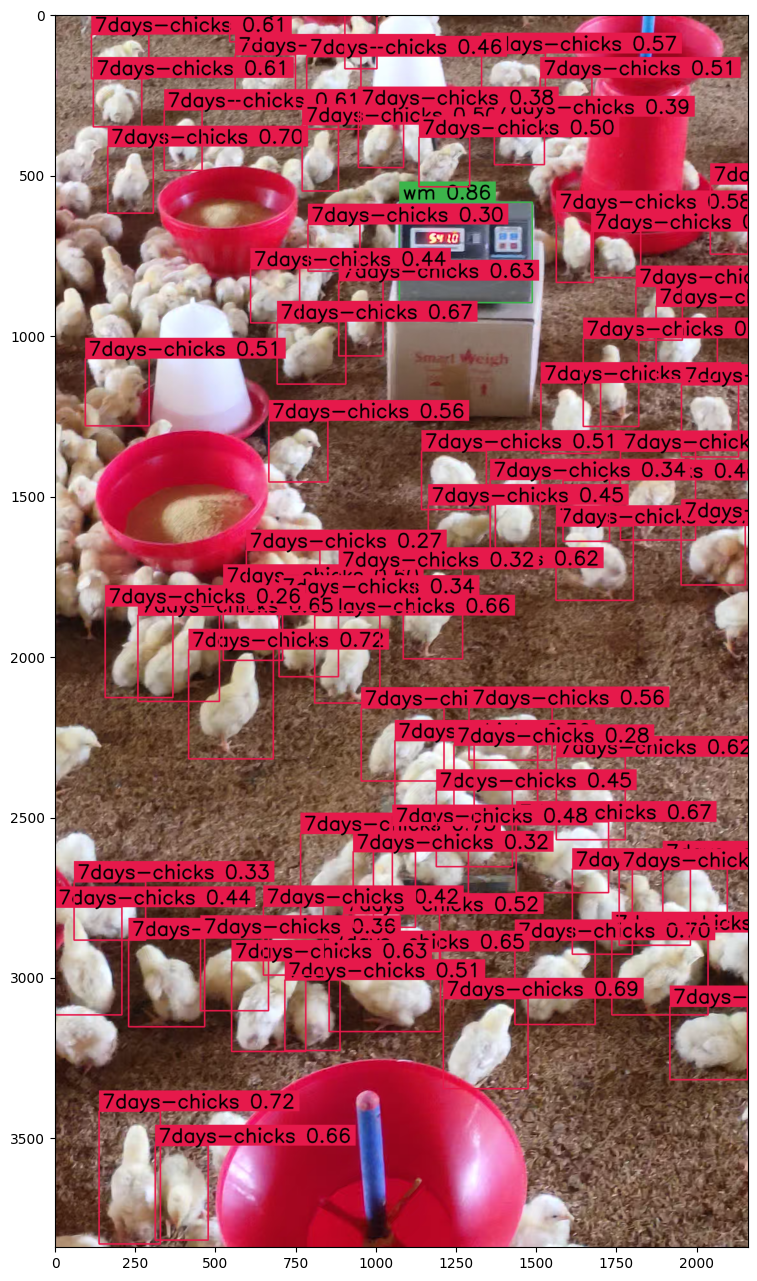

In [21]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [22]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH}

/content/ByteTrack
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source=/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)/Videos/video_20230804_121505.mp4'


Predict and annotate single frame


0: 640x384 72 7days-chickss, 1 wm, 13.8ms
Speed: 3.6ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


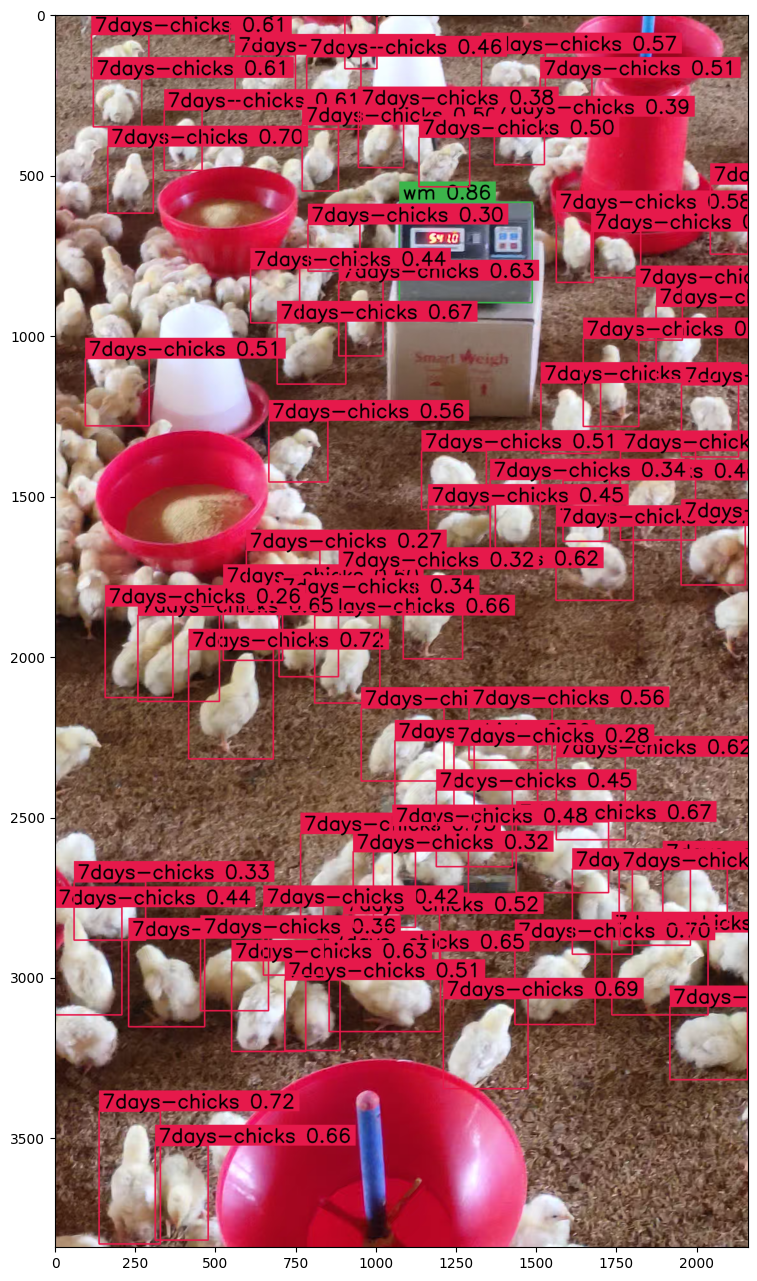

In [55]:
# Define the selected classes
selected_classes = [0, 1]  # Replace with the actual class IDs you want to consider
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

Predict and annotate whole video





In [49]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = '/content/drive/MyDrive/Bird Detection -copy-.v1i.yolov8 (1)/runs/detect/target'

In [50]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=2160, height=3840, fps=30, total_frames=1253)

In [51]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1253 [00:00<?, ?it/s]


0: 640x384 72 7days-chickss, 1 wm, 10.8ms
Speed: 3.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 75 7days-chickss, 1 wm, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 68 7days-chickss, 1 wm, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 67 7days-chickss, 1 wm, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 64 7days-chickss, 1 wm, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 71 7days-chickss, 1 wm, 11.3ms
Speed: 3.4ms preprocess, 11.3ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 69 7days-chickss, 1 wm, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 71 7days

KeyboardInterrupt: ignored

In [53]:
from google.colab.patches import cv2_imshow

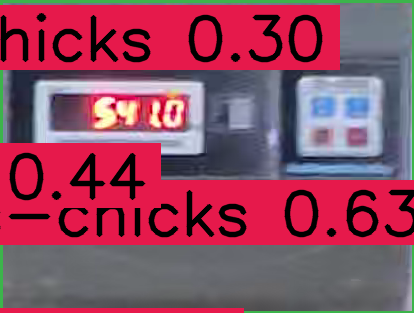

In [61]:
import numpy as np

# Assuming 'frame' contains the original image

# Specify the class you want to extract
class_to_extract = 1  # Replace with the actual class ID you want to extract

# Filter detections for the selected class
selected_class_indices = np.where(detections.class_id == class_to_extract)[0]
selected_boxes = detections.xyxy[selected_class_indices]

# Create a list to store extracted objects
extracted_objects = []

# Extract only the objects of the specified class
for box in selected_boxes:
    x1, y1, x2, y2 = map(int, box)
    extracted_objects.append(frame[y1:y2, x1:x2])

# Display the extracted objects
for obj in extracted_objects:
    cv2_imshow(obj)

In [62]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 6 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,659 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [63]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [64]:
# import the necessary packages
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pytesseract
import cv2
import re

#declaring the exe path for tesseract
pytesseract.pytesseract.tesseract_cmd ='/usr/bin/tesseract'

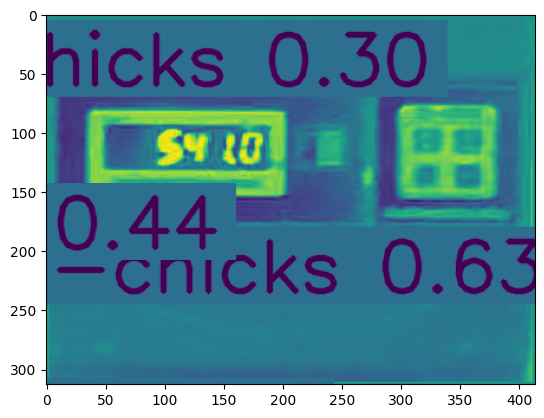

In [65]:
#Load the image
image = obj.copy()

gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1)
plt.grid(False)
plt.show()

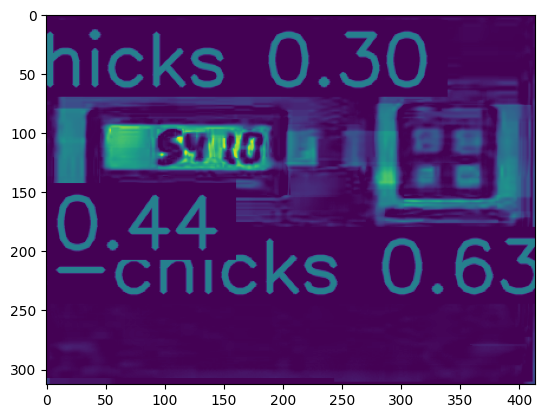

In [66]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray1, (3, 3), 0)
blackhat = cv2.morphologyEx(gray1, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat)

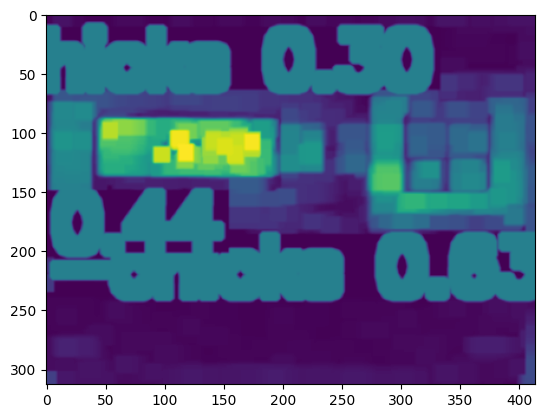

In [67]:
kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilate = cv2.dilate(blackhat, kernal, iterations=3)
blur = cv2.GaussianBlur(dilate, (3, 3), 0)
plt.imshow(blur)

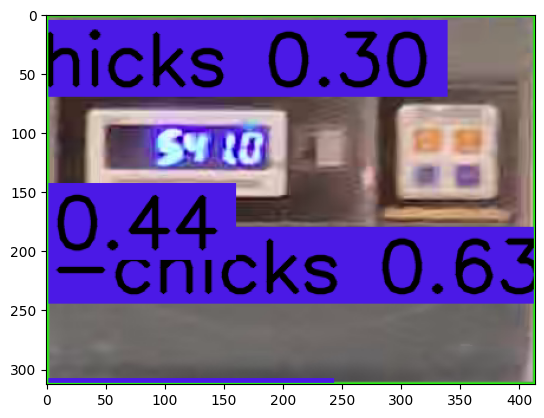

In [70]:
results  = []
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 100 and w > 10:
        cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
        ocr_result = pytesseract.image_to_string(image)
        ocr_result = ocr_result.split("\n")
        for item in ocr_result:
            if item not in results:
                results.append(item)
plt.imshow(image)

In [71]:
print(ocr_result)

[' ', '\x0c']
